### 0. Load packages

In [1]:
import os
import sys

import gpflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import pickle
import scipy as sp
from scipy.sparse import coo_matrix
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *

sys.path.append('../../mogp_decomposition/')
from mwgp import GPD
from data import load_movielens_data_1m

/home/ubuntu/anaconda3/envs/mogp-dev/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/mogp-dev/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/mogp-dev/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/mogp-dev/lib

### 1. Setting random seeds and GPU usage

In [2]:
np.random.seed(123456)
tf.set_random_seed(123456)

### 2. Load data

In [3]:
ml_triple_store = load_movielens_data_1m('../../data/ML-1M/') 

N = ml_triple_store.shape[0]  # number of triples

# Load existent split: 
read_in = open('../../data/ML-1M/splits.pkl', 'rb')
splits = pickle.load(read_in)
read_in.close()

### 3. Collect the prediction for each split

#### including point estimate and predictive variance

In [4]:
# First placeholders for the groundtruth, predictions, predictive variances, 
#  and predictive standard deviations of each split:
Y_te_list = []
pred_list = []
pred_var_list = []
pred_sd_list = []


# Evaluate the models: 
for cv_id in range(5): 
    # For each split, load the target scaler: 
    with open('./ml-1m_scaler_cv'+str(cv_id)+'.pkl', 'rb') as f: 
        this_scaler = pickle.load(f)

    # Just as in training, use the current trunk of split as test and the rest as 
    #  trainign set.
    te_ids = splits[cv_id]
    tr_ids = []
    for i in range(len(splits)): 
        if i != cv_id: 
            tr_ids.append(splits[i])
    tr_ids = np.concatenate(tr_ids)
    
    # Just as in training, load the indices for users and movies from the triple store.
    X_tr = ml_triple_store[tr_ids][:, 0:2]
    Y_tr = this_scaler.transform(ml_triple_store[tr_ids, 3][:, None]).reshape(-1)

    X_te = ml_triple_store[te_ids][:, 0:2]
    Y_te = this_scaler.transform(ml_triple_store[te_ids, 3][:, None]).reshape(-1)

    # The hyper parameters of the model, which are exactly the same as in training. 
    I = ml_triple_store[:, 0].max()+1
    J = ml_triple_store[:, 1].max()+1
    K = None

    hyper_params = {'I':I, 'J':J, 'K':K,
                    'emb_sizes': [8, 8], 
                    'M': 128,  
                    'emb_reg': 1e-4,
                    'batch_size': 2**16, 
                    'obs_mean': Y_tr.mean(), 
                    'lr': 1e-2}
    
    # We initialize the model: 
    gp_md = GPD(**hyper_params)
    # Specify the path to the saved model: 
    gp_md.save_path = './new_ml-1m_M=128_cv'+str(cv_id)+'/'
    # Build the model
    gp_md.build()
    # Load the trained models. 
    gp_md.load_params()
    
    # The direct prediction from the model are in the scaled domain. We have to recover
    #  them in the original ranking domain from 1 to 5. 
    mu1, var1 = gp_md.predict(X_te)  # direct predictions
    
    # The original mean and scale are stored in the scaler object: 
    obs_mean = this_scaler.mean_[0]
    obs_std = this_scaler.scale_[0]
    
    # The recovered prediction: 
    pred = (mu1*obs_std) + obs_mean
    # The recovered predictive variance and std: 
    pred_var = var1 * np.tile(obs_std, (var1.shape[0],1)) ** 2
    pred_sd = pred_var**.5
    
    # Since we rescaled the ground truth, we should recover it as well: 
    Y_te_rescaled = this_scaler.inverse_transform(Y_te)
    
    # We append groundtruth, rescaled prediction, rescaled predictive variance and std to
    #  the corresponding lists that we initialized. 
    Y_te_list.append(Y_te_rescaled)
    pred_list.append(pred)
    pred_var_list.append(pred_var)
    pred_sd_list.append(pred_sd)


Build SVGP



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Build SVGP
Build SVGP
Build SVGP
Build SVGP


### 4. Draw the QP-Plot

In [5]:
# First, define the 10 quantiles: 
qs = np.arange(.1, 1.1, 0.1)

# Second, initialize the list to collect evaluations
maes_list = []
rmses_list = []

# For each split, 
for j in range(5):
    
    # Initialize the maes and rmses w.r.t. 10 quantiles
    maes = np.zeros(10)
    rmses = np.zeros(10)
    
    # For each quantile: 
    for i in range(10):
        # Identify test samples whose predictive standard deviation or variance are smaller
        #  than the q-the quantile. 
        this_q = qs[i]
        thresh = np.quantile(pred_sd_list[j], this_q)
        inds = np.where(pred_sd_list[j] <= thresh)[0]
        
        # Perform evaluation on this set of predictions, by comparing them with the 
        #  corresponding ground truth values.
        maes[i] = mean_absolute_error(y_true=Y_te_list[j][inds], y_pred=pred_list[j][inds])
        rmses[i] = mean_squared_error(y_true=Y_te_list[j][inds], y_pred=pred_list[j][inds])**.5
    maes_list.append(maes)
    rmses_list.append(rmses)
    
# maes_list and rmses_list has 5 components corresponding to the 5 plits, each of which 
#  being a vector of length 10, storing the performance of the top q most confident samples. 

In [6]:
# As a related reference, load performances from GPLVM model.

gplvm_rmses = pd.read_csv('GPLVM_rmses.csv', header=None).values
gplvm_maes = pd.read_csv('GPLVM_maes.csv', header=None).values

In [7]:
gplvm_rmses_df_plot = pd.DataFrame({'quantile': np.tile(qs, 5), 'rmse': gplvm_rmses.reshape(-1)})
gplvm_maes_df_plot = pd.DataFrame({'quantile': np.tile(qs, 5), 'rmse': gplvm_maes.reshape(-1)})

In [8]:
sns.set()

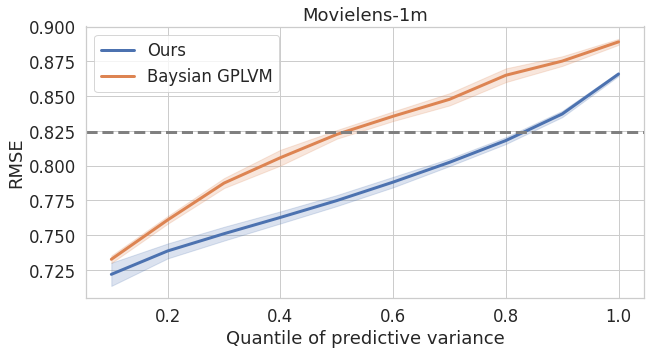

In [9]:
df_plot = pd.DataFrame({'quantile': np.tile(qs, 5), 'rmse': np.concatenate(rmses_list)})

plt.figure(figsize=(10, 5))
# sns.set(font_scale=2)
sns.set(font_scale=1.5, rc={"lines.linewidth": 3})
sns.set_style("whitegrid")
ax = sns.lineplot(x='quantile', y='rmse', data=df_plot, ci='sd')
ax = sns.lineplot(x='quantile', y='rmse', data=gplvm_rmses_df_plot, ci='sd')
plt.axhline(0.824, color='gray', linestyle='--')
plt.legend(['Ours', 'Baysian GPLVM'])
ax.set(xlabel='Quantile of predictive variance', ylabel='RMSE', title='Movielens-1m')
plt.show()

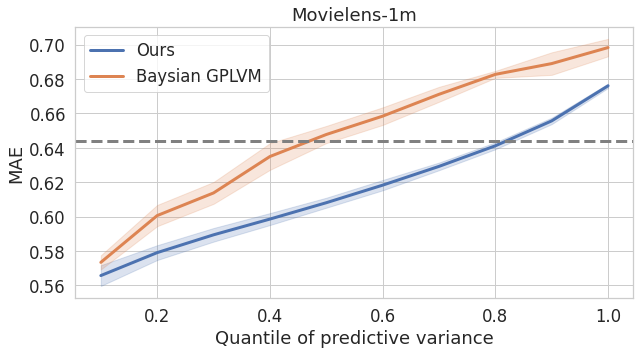

In [10]:
df_plot = pd.DataFrame({'quantile': np.tile(qs, 5), 'mae': np.concatenate(maes_list)})

plt.figure(figsize=(10, 5))
sns.set(font_scale=1.5, rc={"lines.linewidth": 3})
sns.set_style("whitegrid")
ax = sns.lineplot(x='quantile', y='mae', data=df_plot, ci='sd')
ax = sns.lineplot(x='quantile', y='rmse', data=gplvm_maes_df_plot, ci='sd')
plt.axhline(0.644, color='gray', linestyle='--')
plt.legend(['Ours', 'Baysian GPLVM'])
ax.set(xlabel='Quantile of predictive variance', ylabel='MAE', title='Movielens-1m')
plt.show()

In [11]:
# Print the exact performance of our model

# For the 100%, 90%, 80% and 70% most confident predictions: 
for i in [-1, -2, -3, -4]: 
    # The mean and standard deviation of all 5 splits in terms of mae and rmse:
    print(np.array([x[i] for x in maes_list]).mean(), np.array([x[i] for x in maes_list]).std())
    print(np.array([x[i] for x in rmses_list]).mean(), np.array([x[i] for x in rmses_list]).std())

0.6761045039604576 0.001122935637067392
0.8659451815403993 0.0012448317774293636
0.6557032935123904 0.001667609775395085
0.8371731647891163 0.002023556930153261
0.6412111789683337 0.0017937752463407814
0.8180584017322616 0.0022264602322319815
0.629237705194811 0.001990683348936445
0.8023739841897486 0.002430534400453275
